# Кластеризация

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
import inspect
import random
from abc import ABC
from typing import Callable, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
from PIL import Image
from sklearn.datasets import make_blobs, make_moons
from sklearn.neighbors import KDTree
from collections import deque

In [2]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)


# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)
def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")


SEED = 0xC0FFEE
set_seed(SEED)

In [3]:
def visualize_clusters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()


def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter(
            [p[first_color] for p in flatten_image],
            [p[second_color] for p in flatten_image],
            c=flatten_image,
            marker=".",
        )
        axes_pair[1].scatter(
            [p[first_color] for p in flatten_image],
            [p[second_color] for p in flatten_image],
            c=[cluster_colors[c] for c in cluster_labels],
            marker=".",
        )
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

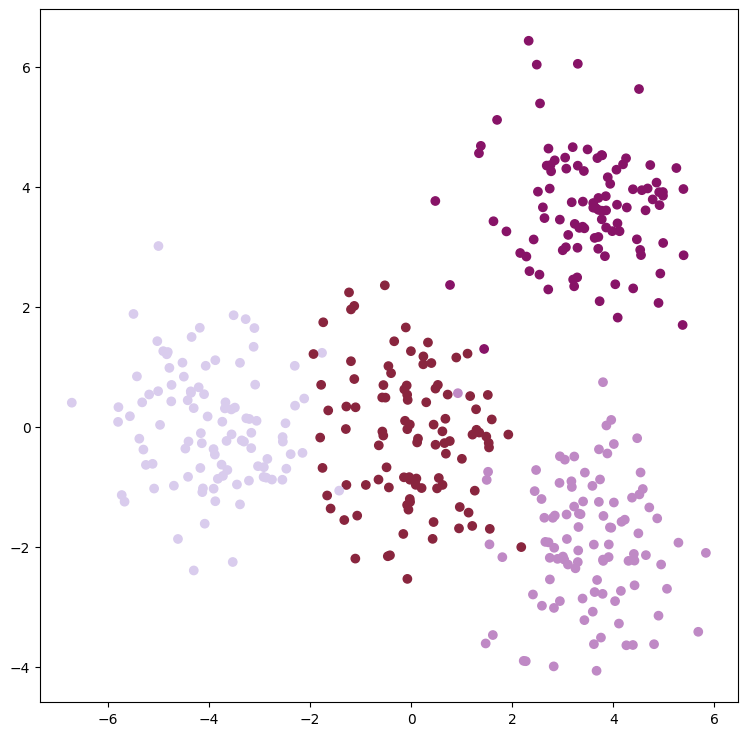

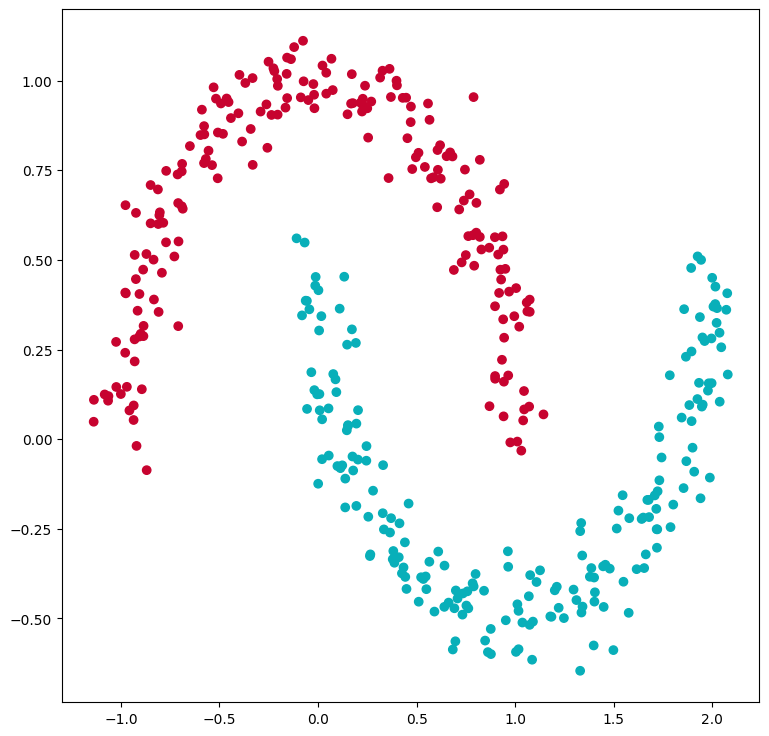

In [4]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clusters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clusters(X_2, true_labels)

Также реализуем необходимые функции для вычисления расстояний между точками

In [5]:
def get_euclidean_distances(from_points: ndarray, to_points: ndarray) -> ndarray:
    """Calculate euclidian distance between points

    Args:
        from_points: array of [source_points; dim] points
        to_points: array of [target_points; dim] points

    Returns:
        distances: array of [source_points; target_points]
    """
    diff = from_points.reshape(-1, 1, from_points.shape[1]) - to_points
    distances = np.sqrt(np.sum(diff ** 2, axis=2))

    return distances


def get_manhattan_distances(from_points: ndarray, to_points: ndarray) -> ndarray:
    """Calculate manhattan distance between points

    Args:
        from_points: array of [source_points; dim] points
        to_points: array of [target_points; dim] points

    Returns:
        distances: array of [source_points; target_points]
    """
    return np.sum(np.abs(from_points - to_points))


def get_chebyshev_distance(from_points: ndarray, to_points: ndarray) -> ndarray:
    """Calculate chebyshev distance between points

    Args:
        from_points: array of [source_points; dim] points
        to_points: array of [target_points; dim] points

    Returns:
        distances: array of [source_points; target_points]
    """
    return np.max(np.abs(from_points - to_points))

## K-Means (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

**Описание методов**

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.

`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

Не забудьте реинициализировать пустые кластеры!

In [6]:
class AbstractCentroidBuilder(ABC):
    name: str = None

    def _generate_centroids(self, x: ndarray, k: int) -> ndarray:
        """Generating centroids from points

        Args:
            x: array of [n_points; dim] points
            k: number of centroids to generate

        """
        raise NotImplementedError()

    @staticmethod
    def _validate_centroids(x: ndarray, centroids: ndarray) -> bool:
        """Validating that each centroid has at least one point next to it"""
        if len(centroids) == 0:
          return False

        distances = get_euclidean_distances(x, centroids)
        closest_centroids = np.argmin(distances, axis=1)

        return len(np.unique(closest_centroids)) == len(centroids)

    def build(self, x: ndarray, k: int) -> ndarray:
        centroids = self._generate_centroids(x, k)
        while not self._validate_centroids(x, centroids):
            centroids = self._generate_centroids(x, k)

        return centroids

class RandomCentroidBuilder(AbstractCentroidBuilder):
    name: str = "random"

    def _generate_centroids(self, x: ndarray, k: int) -> ndarray:
        min_vals = np.min(x, axis=0)
        max_vals = np.max(x, axis=0)

        return np.random.uniform(min_vals, max_vals, size=(k, x.shape[1]))


class SampleCentroidBuilder(AbstractCentroidBuilder):
    name: str = "sample"

    def _generate_centroids(self, x: ndarray, k: int) -> ndarray:
        return x[np.random.choice(len(x), k, replace=False)]


class KMeansPlusCentroidBuilder(AbstractCentroidBuilder):
    name: str = "kmeans++"

    def _generate_centroids(self, x: ndarray, k: int) -> ndarray:
        centroids = np.zeros((k, x.shape[1]))
        centroids[0] = x[np.random.choice(len(x))]

        for i in range(1, k):
            distances = get_euclidean_distances(x, centroids[:i])
            min_distances = np.min(distances, axis=1)

            probabilities = min_distances ** 2 / np.sum(min_distances ** 2)

            next_idx = np.random.choice(len(x), p=probabilities)
            centroids[i] = x[next_idx]

        return centroids

In [7]:
class KMeans:
    _known_centroid_builders: Dict[str, AbstractCentroidBuilder.__class__] = {
        RandomCentroidBuilder.name: RandomCentroidBuilder,
        SampleCentroidBuilder.name: SampleCentroidBuilder,
        KMeansPlusCentroidBuilder.name: KMeansPlusCentroidBuilder,
    }

    _centroids: ndarray = None
    _x: ndarray = None
    _clusters_ids: ndarray = None

    def __init__(self, n_clusters: int, init: str = "random", max_iter: int = 300):
        """KMeans clusterization

        Args:
            n_clusters: number of clusters
            init: strategy to initialize clusters, one of "random", "sample", and "k-means++"
            max_iter: maximum number of iterations
        """
        self._n_clusters = n_clusters
        self._max_iter = max_iter
        if init not in self._known_centroid_builders:
            raise ValueError(f"Unknown way to initialize clusters centroids: {init}")
        self._centroid_builder = self._known_centroid_builders[init]()

    def fit(self, x: ndarray, y: ndarray = None):
        """Build centroids based on X

        Args:
            x: input points, array of [n_points; dim]
            y: ignored, to match sklearn behaviour
        """
        self._x = x
        self._centroids = self._centroid_builder.build(x, self._n_clusters)

        for _ in range(self._max_iter):
            clusters = self.predict(x)

            new_centroids = np.zeros_like(self._centroids)
            for i in range(self._n_clusters):
                cluster_points = x[clusters == i]
                if len(cluster_points) > 0:
                    new_centroids[i] = cluster_points.mean(axis=0)
                else:
                    new_centroids[i] = self._centroids[i]

            if np.allclose(self._centroids, new_centroids):
                break

            self._centroids = new_centroids


    def predict(self, x: np.array) -> np.array:
        """For each element of input returns corresponding cluster index

        Args:
            x: input points, array of [n_points; dim]

        Return
            labels: cluster ids, array of [n_points]
        """
        if self._centroids is None:
            raise RuntimeError("Fit estimator before predicting")

        distances = get_euclidean_distances(x, self._centroids)

        return np.argmin(distances, axis=1)


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

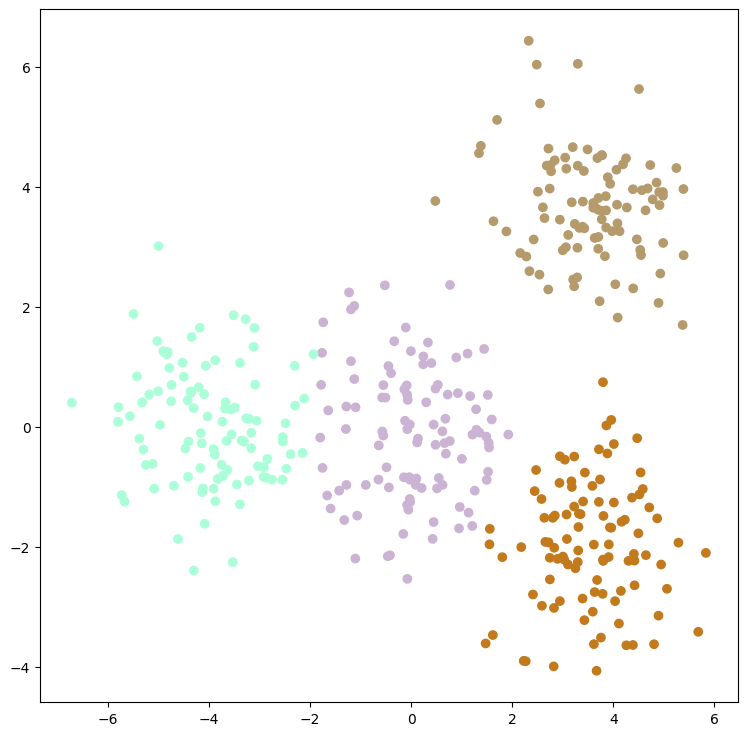

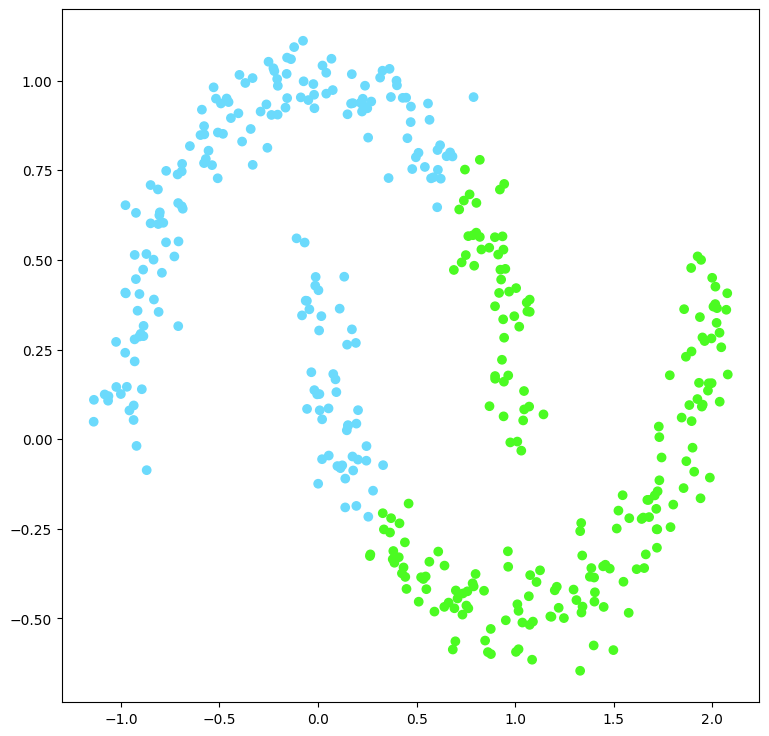

In [8]:
kmeans = KMeans(n_clusters=4, init="kmeans++")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clusters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="kmeans++")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clusters(X_2, labels)

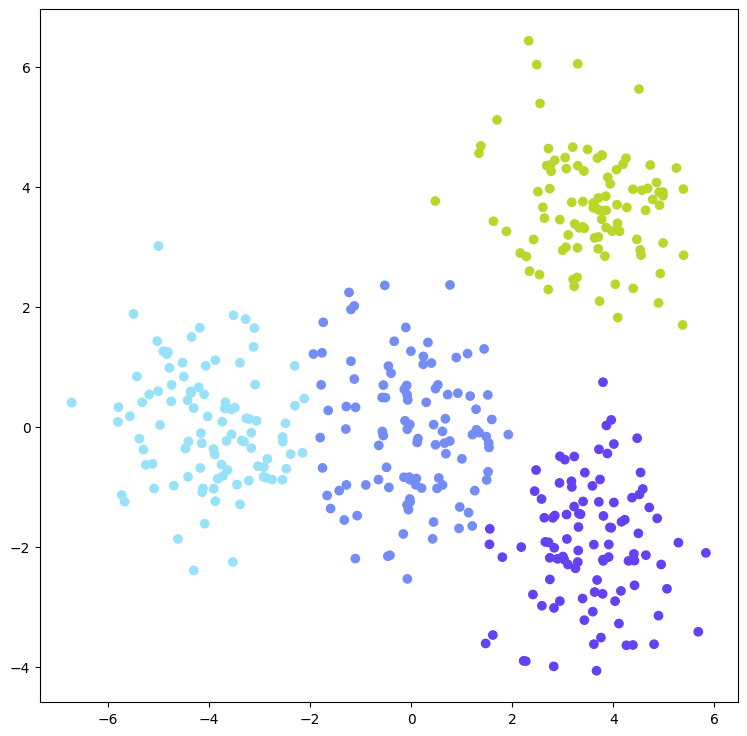

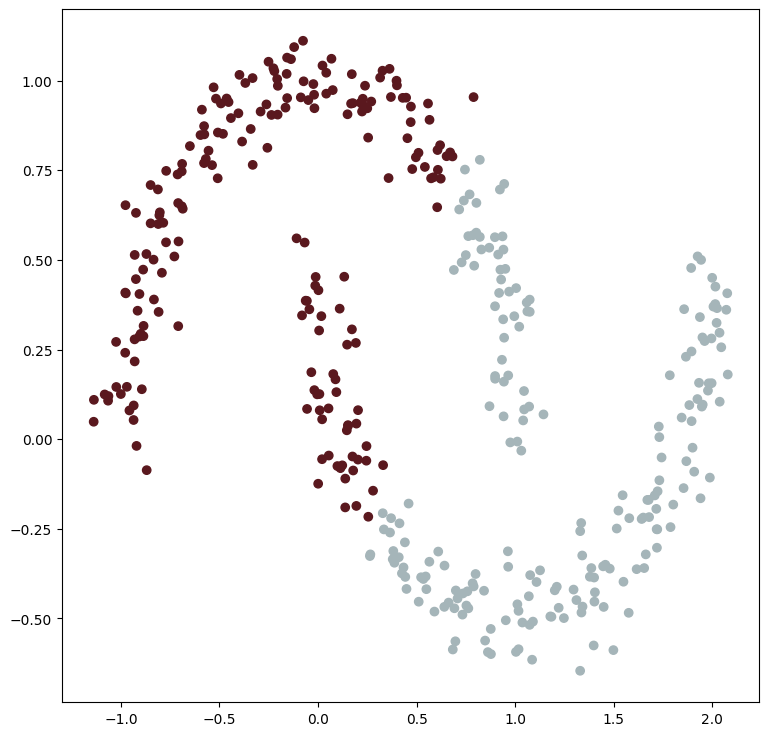

In [9]:
kmeans = KMeans(n_clusters=4, init="sample")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clusters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="sample")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clusters(X_2, labels)

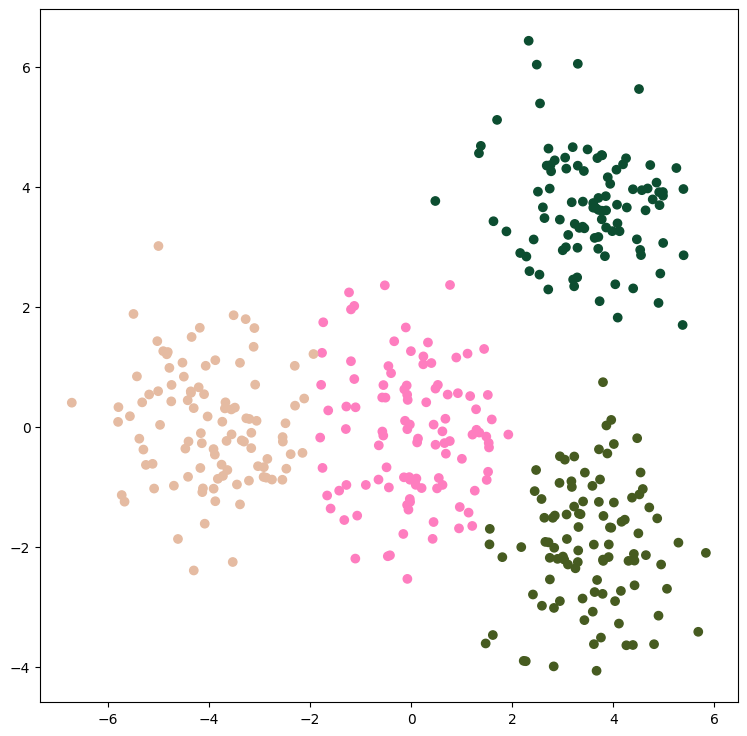

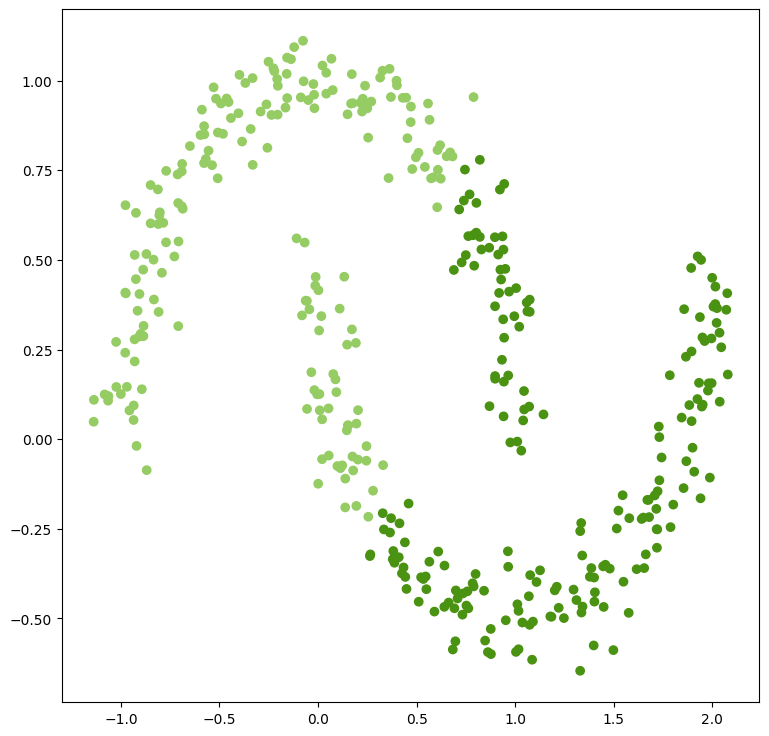

In [10]:
kmeans = KMeans(n_clusters=4, init="random")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clusters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="random")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clusters(X_2, labels)

## DBScan (3 балла)
В отличие от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

**Описание методов**

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

**Возможные метрики**

`euclidean`, `manhattan`, `chebyshev`

Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`

In [ ]:
class DBScan:
    _known_metric_functions: Dict[str, Callable] = {
        "euclidean": get_euclidean_distances,
        "manhattan": get_manhattan_distances,
        "chebyshev": get_chebyshev_distance,
    }

    def __init__(self, eps: float = 0.5, min_samples: int = 5, leaf_size: int = 40, metric: str = "euclidean"):
        """DBScan clusterization

        Args:
            eps, min_samples: parameters for selecting core samples.
                Core samples is a samples with at least `min_samples` samples in their `eps`-neighborhood
            metric: metric to use to calculate distance between samples, one of "euclidean", "manhattan", "chebyshev"
            leaf_size: minimum leaf size for KDTree.
        """

        self._eps = eps
        self._min_samples = min_samples
        if metric not in self._known_metric_functions:
            raise ValueError(f"Unknown metric function: {metric}")
        self._metric = metric
        self._get_distance = self._known_metric_functions[metric]
        self._kdtree_leaf_size = leaf_size

    def fit_predict(self, x: ndarray, y=None) -> ndarray:
        """Cluterize and return index for each point in x

        Args:
            x: input points, array of [n_points; dim]
            y: ignored, to mactch sklearn behaviour
        Return
            labels: cluster ids, array of [n_points]
        """
        n_samples = x.shape[0]
        labels = np.full(n_samples, -2, dtype=int)

        current_cluster_id = 0
        tree = KDTree(x, leaf_size=self._kdtree_leaf_size, metric=self._metric)

        for i in range(len(x)):
            if labels[i] != -2:
                continue

            neighbors = tree.query_radius(x[i].reshape(1, -1), r=self._eps)[0]

            if len(neighbors) < self._min_samples:
                labels[i] = -1
                continue

            queue = deque(neighbors)

            labels[i] = current_cluster_id

            while queue:
                current_point = queue.popleft()

                if labels[current_point] == -1:
                    labels[current_point] = current_cluster_id
                elif labels[current_point] == -2:
                    labels[current_point] = current_cluster_id

                    new_neighbors = tree.query_radius(x[current_point].reshape(1, -1), r=self._eps)[0]
                    if len(new_neighbors) >= self._min_samples:
                        queue.extend(n for n in new_neighbors if labels[n] == -2)
            current_cluster_id += 1

        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

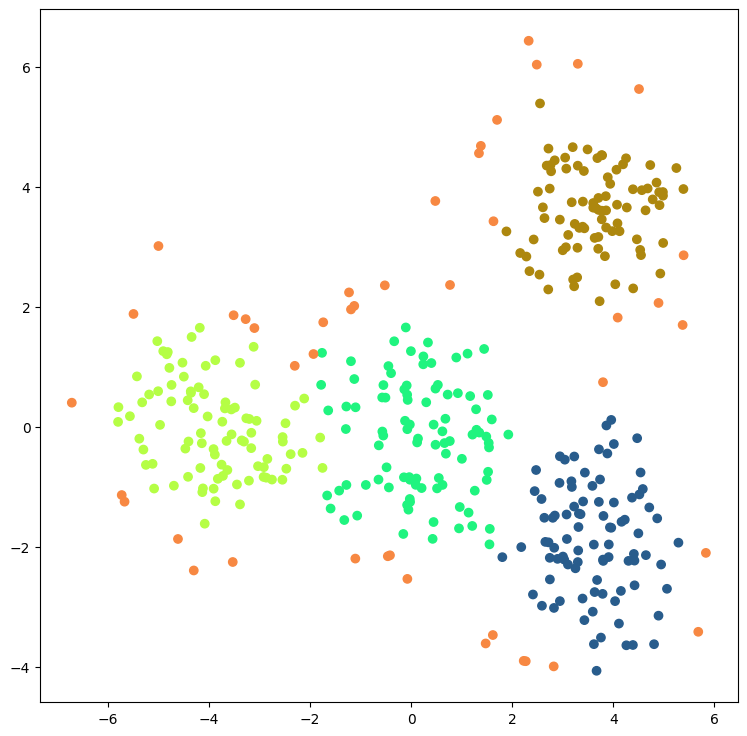

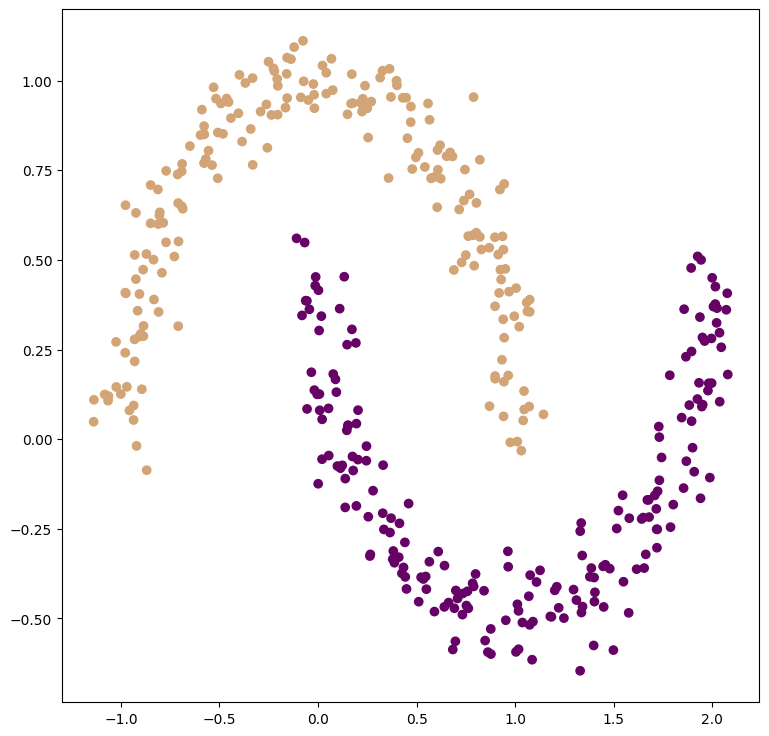

In [ ]:
dbscan = DBScan(eps = 0.8, min_samples = 12)
labels = dbscan.fit_predict(X_1)
visualize_clusters(X_1, labels)

dbscan = DBScan(eps = 0.2)
labels = dbscan.fit_predict(X_2)
visualize_clusters(X_2, labels)

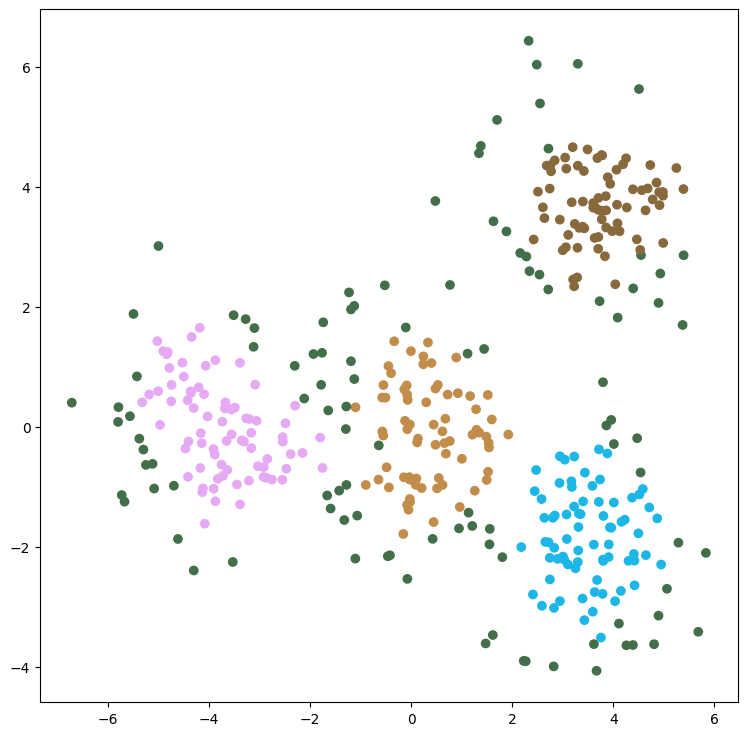

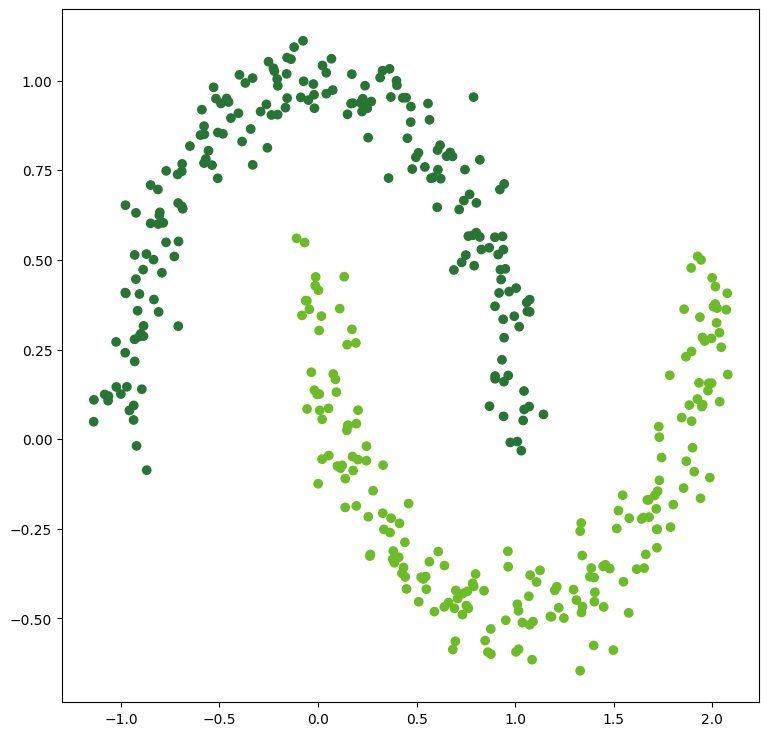

In [ ]:
dbscan = DBScan(eps = 0.8, min_samples = 12, metric='manhattan')
labels = dbscan.fit_predict(X_1)
visualize_clusters(X_1, labels)

dbscan = DBScan(eps = 0.25, metric='manhattan')
labels = dbscan.fit_predict(X_2)
visualize_clusters(X_2, labels)

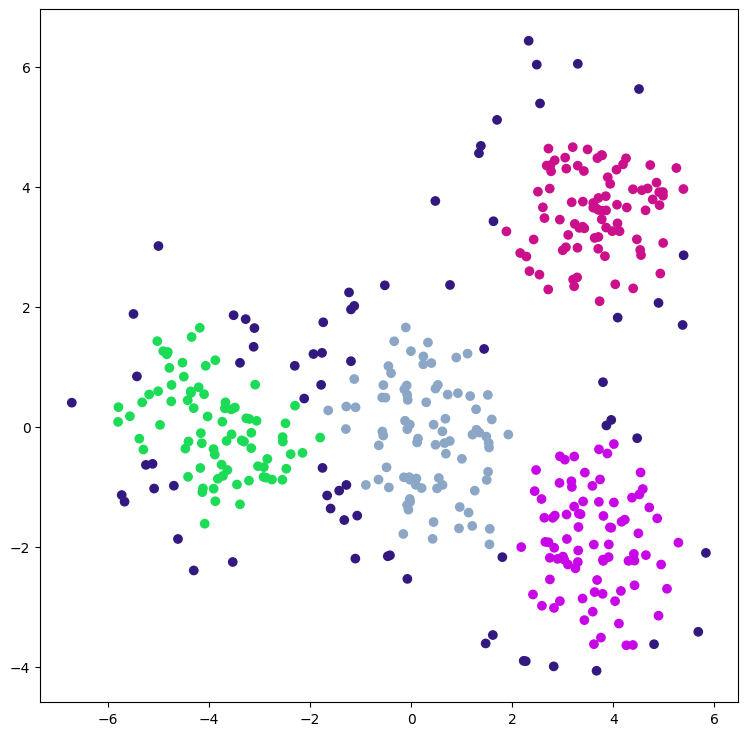

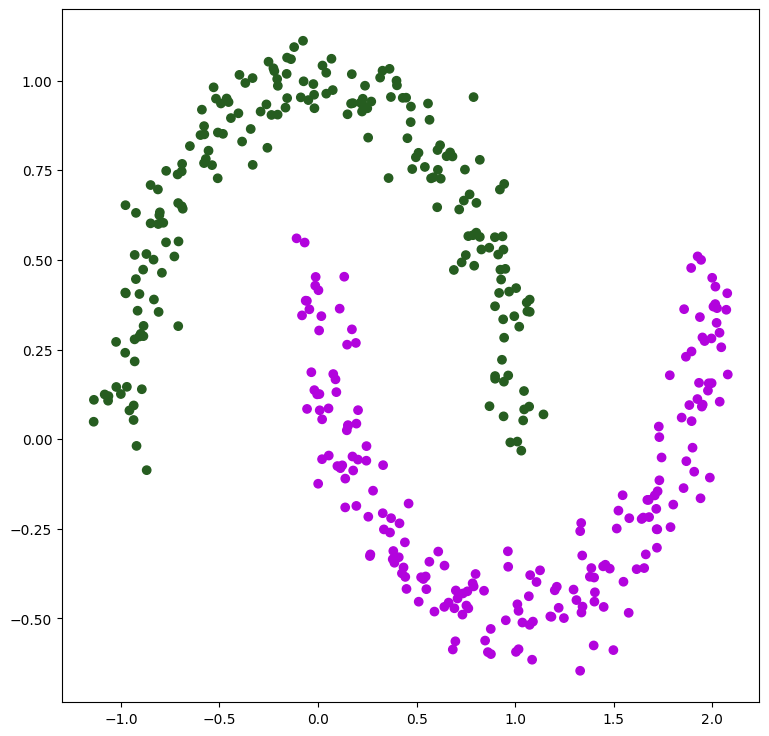

In [ ]:
dbscan = DBScan(eps = 0.6, min_samples = 10, metric='chebyshev')
labels = dbscan.fit_predict(X_1)
visualize_clusters(X_1, labels)

dbscan = DBScan(eps = 0.2, metric='chebyshev')
labels = dbscan.fit_predict(X_2)
visualize_clusters(X_2, labels)

## Agglomerative Clustering (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

**Описание методов**

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

### Linkage
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

Для быстрого вычисления воспользуемся формулой Ланса-Уильямса

$$
D(W, S) = \alpha_U D(U, S) + \alpha_V D(V, S) + \beta D(U, V) + \gamma \left| D(U, S) - D(V, S) \right|
$$


| Метод агломерации         | α<sub>U</sub>                             | α<sub>V</sub>                             | β                                       | γ       |
|--------------------------|------------------------------------------|------------------------------------------|-----------------------------------------|----------|
| Single linkage           | 0.5                                      | 0.5                                      | 0                                       | -0.5     |
| Complete linkage         | 0.5                                      | 0.5                                      | 0                                       | +0.5     |
| Average linkage          | n<sub>U</sub> / (n<sub>U</sub> + n<sub>V</sub>) | n<sub>V</sub> / (n<sub>U</sub> + n<sub>V</sub>) | 0                                       | 0        |
| Centroid linkage         | n<sub>U</sub> / (n<sub>U</sub> + n<sub>V</sub>) | n<sub>V</sub> / (n<sub>U</sub> + n<sub>V</sub>) | -n<sub>U</sub>n<sub>V</sub> / (n<sub>U</sub> + n<sub>V</sub>)² | 0        |
| Ward's method            | (n<sub>S</sub> + n<sub>U</sub>) / (n<sub>S</sub> + n<sub>U</sub> + n<sub>V</sub>) | (n<sub>S</sub> + n<sub>V</sub>) / (n<sub>S</sub> + n<sub>U</sub> + n<sub>V</sub>) | -n<sub>S</sub> / (n<sub>S</sub> + n<sub>U</sub> + n<sub>V</sub>) | 0        |

In [ ]:
# Return coefficients based on Lance–Williams formula for different linkages


def get_average_linkage_params(u_size: int, v_size: int) -> Tuple[float, float, float, float]:
    sum = u_size + v_size
    alpha_u = u_size / sum
    alpha_v = v_size / sum
    beta = 0.0
    gamma = 0.0
    return (alpha_u, alpha_v, beta, gamma)


def get_single_linkage_params(u_size: int, v_size: int) -> Tuple[float, float, float, float]:
    alpha_u = 0.5
    alpha_v = 0.5
    beta = 0.0
    gamma = -0.5
    return (alpha_u, alpha_v, beta, gamma)


def get_complete_linkage_params(u_size: int, v_size: int) -> Tuple[float, float, float, float]:
    alpha_u = 0.5
    alpha_v = 0.5
    beta = 0.0
    gamma = 0.5
    return (alpha_u, alpha_v, beta, gamma)

In [ ]:
class AgglomerativeClustering:

    _known_linkages = {
        "average": get_average_linkage_params,
        "single": get_single_linkage_params,
        "complete": get_complete_linkage_params,
    }

    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """Agglomerative clusterization

        Args:
            n_clusters: number of clusters
            linkage: linkage to use, one of "average", "single", and "complete"
        """
        self._n_clusters = n_clusters
        if linkage not in self._known_linkages:
            raise ValueError(f"Unknown linkage: {linkage}")
        self._linkage = self._known_linkages[linkage]

    def fit_predict(self, x: ndarray, y=None) -> ndarray:
        """Cluterize and return index for each point in x

        Args:
            x: input points, array of [n_points; dim]
            y: ignored, to mactch sklearn behaviour
        Return
            labels: cluster ids, array of [n_points]
        """
        n_points = x.shape[0]

        dist_matrix = self._compute_distance_matrix(x)

        clusters = [[i] for i in range(n_points)]
        active_indices = list(range(n_points))

        while len(active_indices) > self._n_clusters:
            i, j = self._find_closest_clusters(dist_matrix, active_indices)

            clusters[i].extend(clusters[j])

            self._update_distances(dist_matrix, active_indices, i, j)

            active_indices.remove(j)

        return self._create_labels(clusters, active_indices, n_points)

    def _compute_distance_matrix(self, x: ndarray) -> ndarray:
        n_points = x.shape[0]
        dist_matrix = np.zeros((n_points, n_points))

        for i in range(n_points):
            for j in range(i+1, n_points):
                dist_matrix[i,j] = dist_matrix[j,i] = np.linalg.norm(x[i] - x[j])
        np.fill_diagonal(dist_matrix, np.inf)

        return dist_matrix

    def _find_closest_clusters(self, dist_matrix: ndarray, active_indices: list[int]) -> Tuple[int, int]:
        min_dist = np.inf
        merge_i, merge_j = -1, -1

        for idx_a, i in enumerate(active_indices[:-1]):
            for j in active_indices[idx_a+1:]:
                if dist_matrix[i,j] < min_dist:
                    min_dist = dist_matrix[i,j]
                    merge_i, merge_j = i, j

        return merge_i, merge_j

    def _update_distances(self, dist_matrix: ndarray, active_indices: list[int], i: int, j: int) -> None:
        size_i = len([k for k in active_indices if k == i])
        size_j = len([k for k in active_indices if k == j])

        alpha_i, alpha_j, beta, gamma = self._linkage(size_i, size_j)

        for k in active_indices:
            if k == i or k == j:
                continue

            dist_ki = dist_matrix[k,i]
            dist_kj = dist_matrix[k,j]
            dist_ij = dist_matrix[i,j]

            new_dist = (alpha_i * dist_ki + alpha_j * dist_kj + beta * dist_ij + gamma * abs(dist_ki - dist_kj))
            dist_matrix[k,i] = dist_matrix[i,k] = new_dist

        dist_matrix[j,:] = np.inf
        dist_matrix[:,j] = np.inf

    def _create_labels(self, clusters: list[list[int]], active_indices: list[int], n_points: int) -> ndarray:
        labels = np.full(n_points, -1, dtype=int)
        for cluster_id, root_idx in enumerate(active_indices):
            for point_idx in clusters[root_idx]:
                labels[point_idx] = cluster_id

        return labels


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

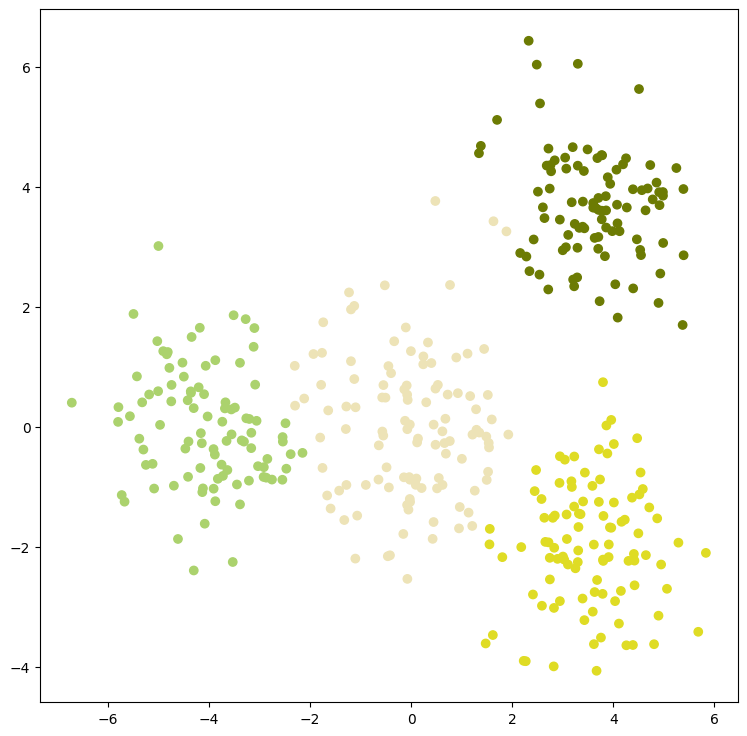

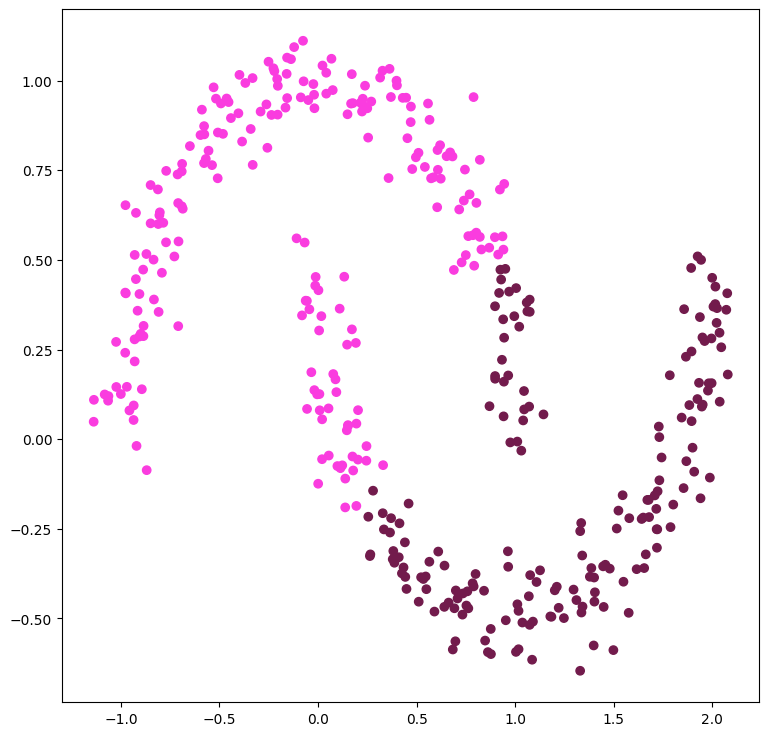

In [ ]:
agg_clustering = AgglomerativeClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clusters(X_1, labels)

agg_clustering = AgglomerativeClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clusters(X_2, labels)

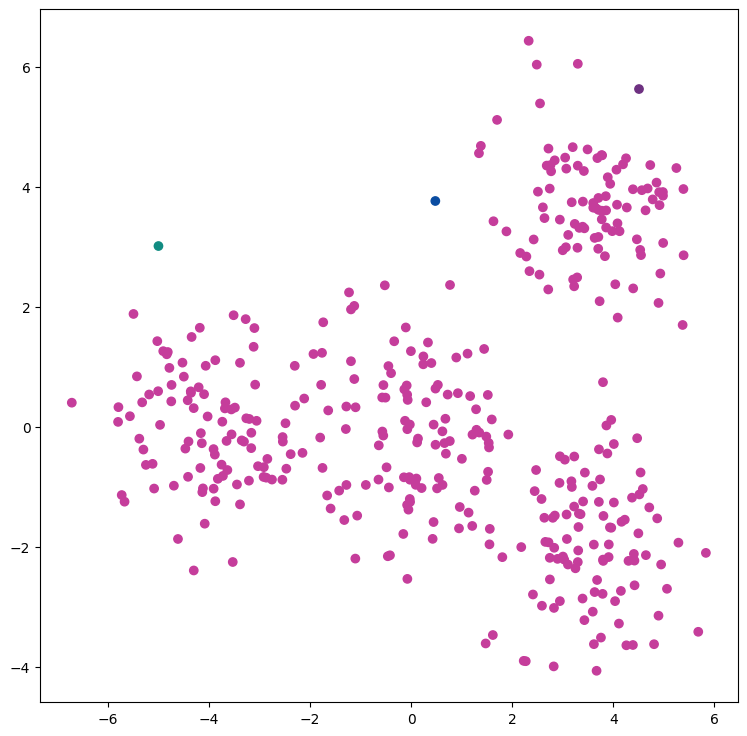

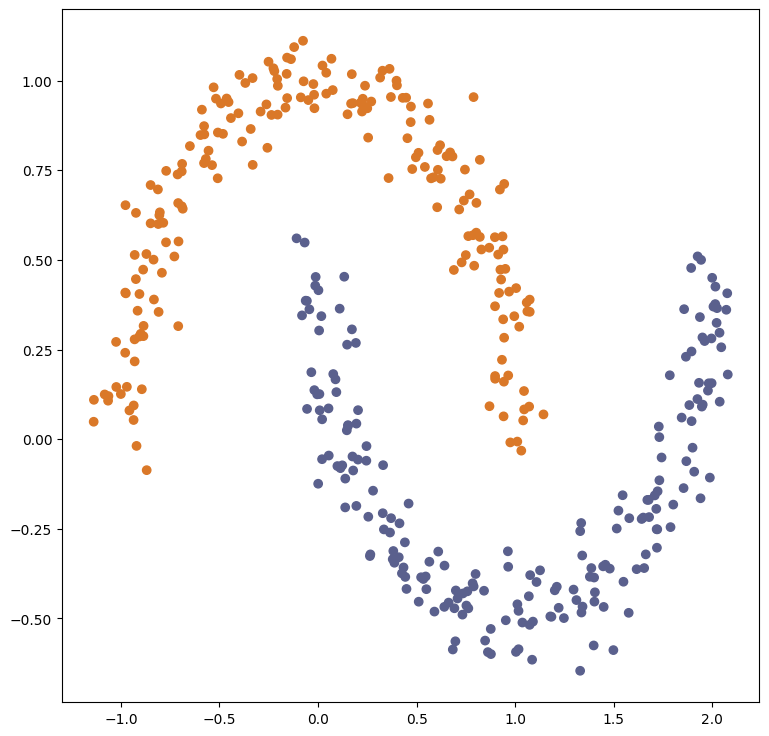

In [ ]:
agg_clustering = AgglomerativeClustering(n_clusters=4, linkage='single')
labels = agg_clustering.fit_predict(X_1)
visualize_clusters(X_1, labels)

agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='single')
labels = agg_clustering.fit_predict(X_2)
visualize_clusters(X_2, labels)

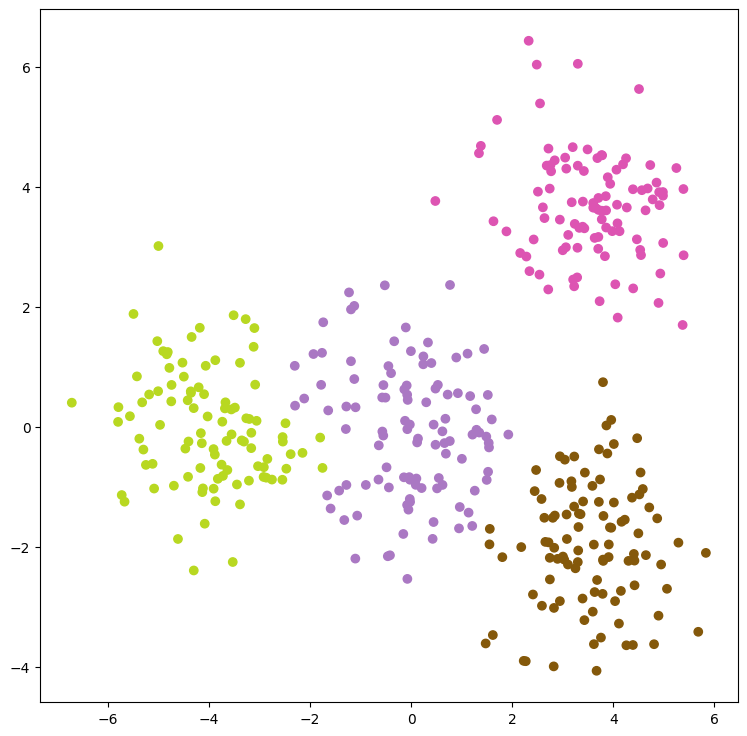

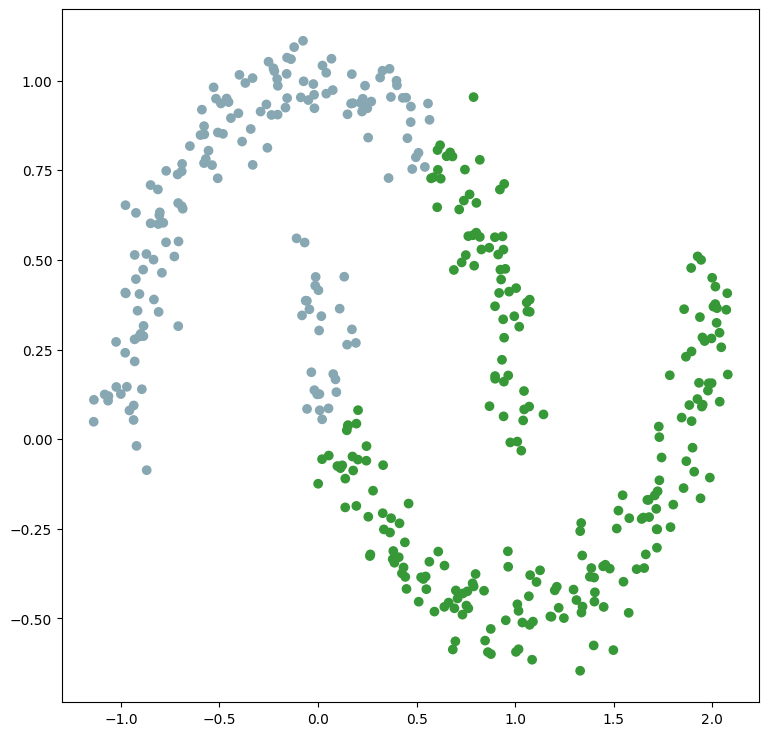

In [ ]:
agg_clustering = AgglomerativeClustering(n_clusters=4, linkage="complete")
labels = agg_clustering.fit_predict(X_1)
visualize_clusters(X_1, labels)

agg_clustering = AgglomerativeClustering(n_clusters=2, linkage="complete")
labels = agg_clustering.fit_predict(X_2)
visualize_clusters(X_2, labels)

## Сжатие изображений (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки [`Pillow`](https://github.com/python-pillow/Pillow).

Нормализованное изображение - это изображение, у которого все значения пикселей находятся в $[0; 1]$.

In [ ]:
def read_image(path: str) -> ndarray:
    """Read and return image from file

    Args:
        path: path to the image file

    Return:
        image: normalized image array of shape [H, W, 3]
    """
    img = Image.open(path)
    norm_img = np.array(img) / 255.0

    return norm_img


def show_image(image: ndarray):
    """Display the image using matplotlib

    Args:
        image: normalized image array of shape [H, W, 3]
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def save_image(image: ndarray, path: str):
    """Save the image to file

    Args:
        image: normalized image array of shape [H, W, 3]
        path: path to save the image
    """
    img = Image.fromarray((image * 255).astype(np.uint8))
    img.save(path)

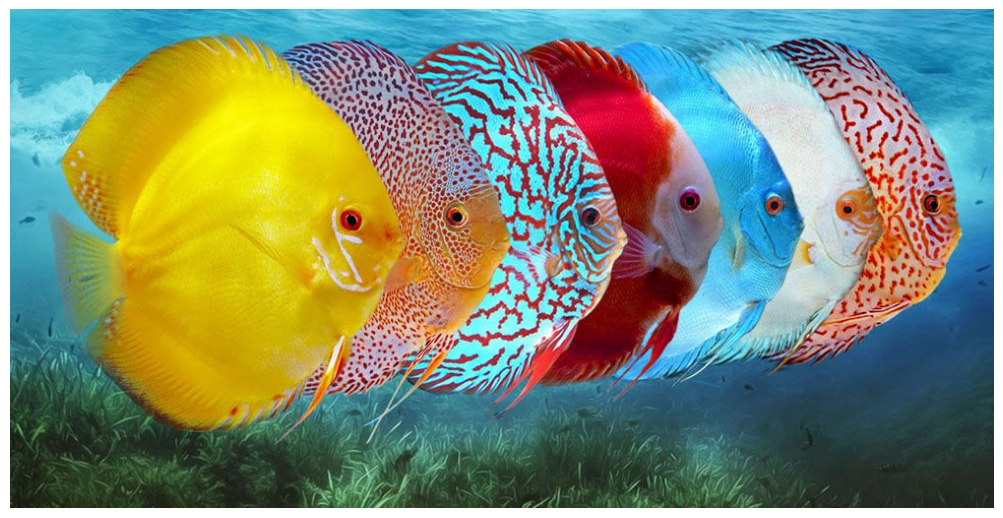

In [ ]:
# Put your favorite image and read it
image_path = "fish.jpg"

image = read_image(image_path)
show_image(image)

Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [ ]:
def clusterize_image(image: ndarray, n_clusters: int):
    model = KMeans(n_clusters=n_clusters)
    model.fit(image.reshape(-1, 3))
    cluster_colors = model._centroids
    clusters = model.predict(image.reshape(-1, 3))
    recolored = cluster_colors[clusters].reshape(image.shape)

    clusters_statistics(image.reshape(-1, 3), cluster_colors, clusters)  # Very slow (:
    return recolored

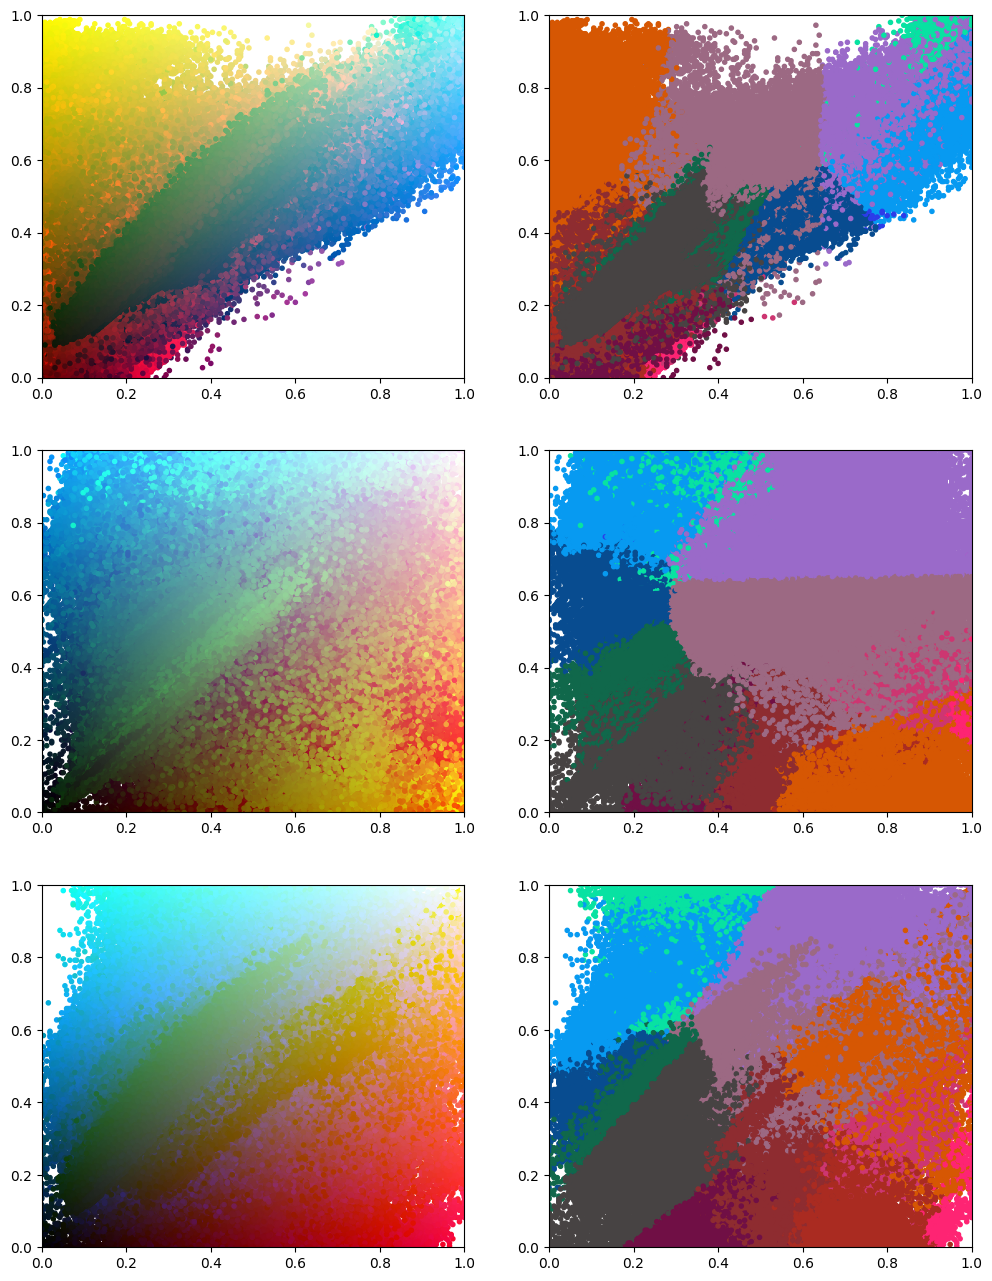

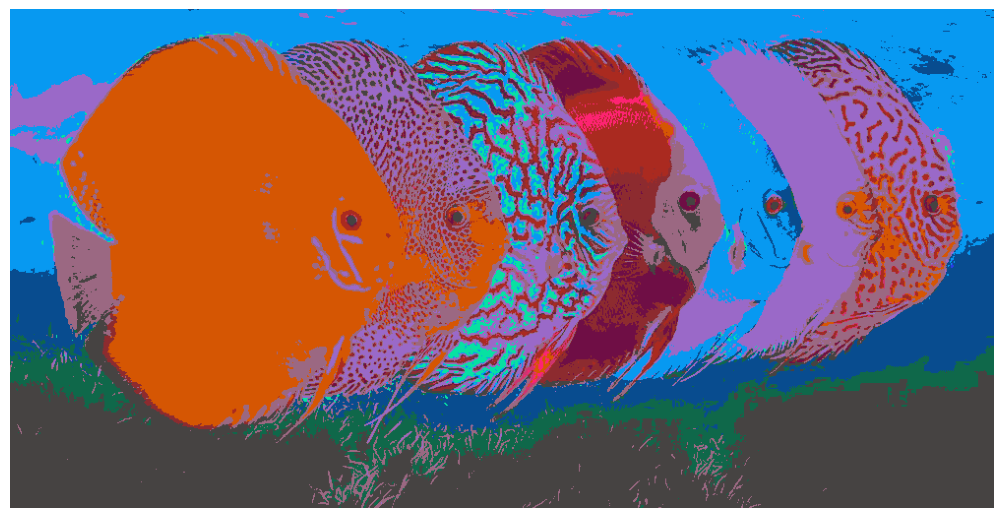

In [ ]:
image = read_image(image_path)
result = clusterize_image(image, 15)
show_image(result)
save_image(result, "result.jpg")